In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

class Inception(nn.Module):
    # c1--c4是每条路径的输出通道数
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # 线路1，单1x1卷积层
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # 线路2，1x1卷积层后接3x3卷积层
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # 线路3，1x1卷积层后接5x5卷积层
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # 线路4，3x3最大汇聚层后接1x1卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # 在通道维度上连结输出
        return torch.cat((p1, p2, p3, p4), dim=1)

In [8]:
class GoogleNet(nn.Module):
  def __init__(self,in_channels,classes):
    super(GoogleNet,self).__init__()
    self.model = nn.Sequential(
              nn.Conv2d(in_channels,out_channels=64,kernel_size=7,stride=2,padding=3),nn.ReLU(),
              nn.MaxPool2d(kernel_size=3,stride=2),
              nn.Conv2d(in_channels=64,out_channels=64,kernel_size=1),nn.ReLU(),
              nn.Conv2d(in_channels=64,out_channels=192,kernel_size=3,padding=1),nn.ReLU(),
              nn.MaxPool2d(kernel_size=3,stride=2),
              Inception(192,c1=64,c2=[96,128],c3=[16,32],c4=32),
              Inception(256,c1=128,c2=[128,192],c3=[32,96],c4=64),
              nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
              Inception(480,c1=192,c2=[96,208],c3=[16,48],c4=64),
              Inception(512,c1=160,c2=[112,224],c3=[24,64],c4=64),
              Inception(512,c1=128,c2=[128,256],c3=[24,64],c4=64),
              Inception(512,c1=112,c2=[144,288],c3=[32,64],c4=64),
              Inception(528,c1=256,c2=[160,320],c3=[32,128],c4=128),
              nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
              Inception(832,c1=256,c2=[160,320],c3=[32,128],c4=128),
              Inception(832,c1=384,c2=[192,384],c3=[48,128],c4=128),
              nn.AdaptiveAvgPool2d((1,1)),
              nn.AvgPool2d(kernel_size=7,stride=1),
              nn.Flatten(),
              nn.Linear(1024,classes),
              nn.Softmax(dim=1)
            )
  def forward(self,X:torch.tensor):
    for layer in self.model:
      X = layer(X)
    # return X
      print(layer.__class__.__name__,'output shape:',X.shape)

In [2]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

loss 0.239, train acc 0.909, test acc 0.879
2517.9 examples/sec on cuda:0


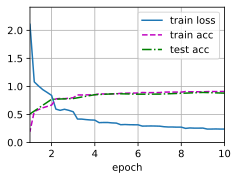

In [3]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [86]:
nnet = nn.Linear(4,2,bias=False)
x = torch.ones(2,4)
nnet(x),x,nnet.weight.data

(tensor([[-1.2198, -0.1805],
         [-1.2198, -0.1805]], grad_fn=<MmBackward0>),
 tensor([[1., 1., 1., 1.],
         [1., 1., 1., 1.]]),
 tensor([[-0.3743, -0.4724, -0.4916,  0.1185],
         [-0.3741, -0.1565,  0.3749, -0.0249]]))

In [90]:
nnet.weight.data.T

tensor([[-0.3743, -0.3741],
        [-0.4724, -0.1565],
        [-0.4916,  0.3749],
        [ 0.1185, -0.0249]])